# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from fastai.text import *


## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
#I have a file full of the training, development and test set data. Why one file containing all the data?
#I'm going to use this data to fine-tune the wiki103 Language Model into a meetings Language model. I want
#as much meeting text as I can get to fine-tune the LM and that's what this file is for.


In [4]:
#There are problems with the action items csv. I get UnicodeDecodeError: 'utf8' codec can't decode byte whatever in position whatever: invalid start byte
#fastai course talks about this here: https://youtu.be/CJKnDu2dxOE?t=2414
#You can avoid it when loading into a pandas dataframe by going
#****************df = pd.read_csv(path, encoding='latin-1')*********************

#But I'm not loading it directly into a pandas dataframe. So here's what I did:
#Open up train_balanced_4.csv in Excel. The first column should be label
#The second column should be text. Save as a tab delimited text file. This, I think,
#gets rid of any weird encodings.
#Then load up the tab delimited text file into Excel and then save as a csv.

path = "../action-items-data/data-originals/train-dev-test.csv"
f  = open(path,"rb")
text = f.read().decode(errors='replace')


In [5]:
f = open('../action-items-data/data-for-fastai/train-dev-test2.csv', 'w')
f.write(text)
f.close()


In [4]:
#Now we can properly load into fastai object
path = "../action-items-data/data-for-fastai/"
#data_for_lm = TextClasDataBunch.from_csv(path, 'train-dev-test2.csv')
data_for_lm = TextLMDataBunch.from_csv(path, 'train-dev-test2.csv')
data_for_lm.show_batch()


idx,text
0,"xxmaj ken can you hear me . xxbos xxmaj and try to figure out a way that we can bring summaries and action items to the forefront on the dashboard . xxbos i can move that up in the queue of what i 'm working on then . xxbos a month in , it 's like , xxmaj hey , there 's a project xxunk . xxbos 'cause , like"
1,"and last thing , i 'm hoping to touch on that this afternoon is i got ta finish up my stuff here , just go through that site survey i did , make sure i have everything because i need to prepare to xxunk those xxup ip back out with xxunk series so we can send those 20 of those xxmaj xxunk back . xxbos been working daily at an"
2,"to happen , right ? xxbos if we could just have a touch point with him on the setting up a lunch and learn or even having a conversation with him , that 'd be awesome . xxbos xxmaj we 'll work on trying to xxunk those and get those in the xxunk and the thing with xxmaj hendricks is the more you use it the better it gets ,"
3,", so . xxbos i just xxunk an interesting problem that i then tried to create a new one and i then have xxunk something because the invoice that i usually use to create it is now responding with a , xxmaj hey . xxbos xxmaj that 's the xxunk of the way that we started to separate things . xxbos xxmaj so the interesting thing about this is we"
4,"a community , right . xxbos xxmaj so we just xxunk off an eight week development cycle with xxup ibm 's blue xxunk xxunk team in xxmaj toronto , so i have four xxunk working on the project right now here locally . xxbos i need to talk to xxmaj paul before i work on the blog post . xxbos xxmaj then when he xxunk that he 's going to"


In [7]:
#data_for_lm.save()

In [8]:
print(type(data_for_lm))

<class 'fastai.text.data.TextLMDataBunch'>


The texts have been tokenized. The tokenizer did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [9]:
data_for_lm.vocab.itos[:5]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [10]:
data_for_lm.train_ds[0][0]

Text xxbos xxmaj let me know .

But the underlying data is all numbers

In [11]:
data_for_lm.train_ds[0][0].data[:10]

array([  2,   5, 108,  67,  46,  10])

In [12]:
#Now let's do the same as above for the train-dev set. This dataset will be used to train the classifier
path = "../action-items-data/data-originals/train-dev.csv"
g  = open(path,"rb")
text = g.read().decode(errors='replace')

g = open('../action-items-data/data-for-fastai/train-dev2.csv', 'w')
g.write(text)
g.close()


In [13]:
#Now we can properly load into fastai object
path = "../action-items-data/data-for-fastai/"

data_for_classifier = (TextList.from_csv(path, 'train-dev2.csv', cols='text', vocab=data_for_lm.vocab)
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())


data_for_classifier.show_batch()


text,target
"xxbos xxmaj so , i was under the xxunk that , if we could work from that document and um , since you guys knew xxmaj xxunk and xxmaj havana xxmaj club , um , the best as far as like why they would , uh , you know , uh , potentially see value in something like this , especially around the the engagement that we were building around",1
"xxbos i got ta go buy , go get , xxunk me , just go grab a box of cable and make that 35 foot cable for the tower , for xxunk and also four short xxunk xxunk for xxunk up 18 to extend those ones that do n't reach the patch panel , and once i got those xxunk in the patch panel i got ta get into netdoc",1
"xxbos xxmaj so , but if you could do something quickly , to either xxunk that yeah , okay , it has the exact same problem that xxmaj watson has , and that it 's like , okay , double down on hopefully having xxup ibm figure it out , or if for some reason it does n't get xxunk down , then it 's like , you know ,",1
"xxbos xxmaj yeah , so , i think , obviously , some of the good next steps here is , uh , xxmaj xxunk will xxunk that scope of work , um , i mean he had a really good idea when we were on the phone this past week in terms of what the xxunk are and - and just the - the executive summary and stuff , so",1
"xxbos xxmaj and the purpose of this meeting as we continue to develop and fine xxunk what will ultimately be the report on the 14th , and that 's in calendar , is that we want to take xxmaj if you look at the agenda today , , what we have in the agenda is , i do n't want to call it a laundry list , but i would",1


In [14]:
data_for_lm.vocab.itos[:5]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld']

In [15]:
data_for_lm.save('data_for_language_model.pkl')


In [16]:
data_for_classifier.train_ds[0][0]

Text xxbos xxmaj so what i want to check on this , is go back to the one 's that xxmaj xxunk 's having issues with , and see if you can xxunk the xxunk .

In [17]:
data_for_classifier.train_ds[0][0].data[:10]

array([  2,   5,  21,  35,  13,  71,  12, 188,  24,  39])

In [18]:
data_for_classifier.valid_ds[0][0]

Text xxbos xxmaj and i did some updates on the slides .

In [19]:
data_for_classifier.valid_ds[0][0].data[:10]

array([   2,    5,   14,   13,  134,   58, 1382,   24,   11,  998])

In [20]:
data_for_classifier.save('data_clas.pkl')

## Language model

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [21]:
learn = language_model_learner(data_for_lm, AWD_LSTM, drop_mult=0.3)


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


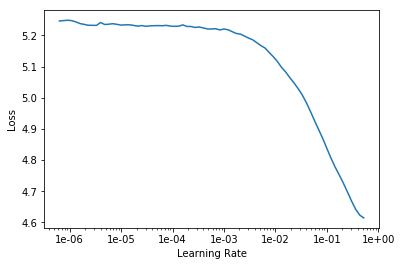

In [23]:
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.947279,4.531560,0.219048,00:03


In [25]:
learn.save('fit_head')

In [26]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.543481,4.257114,0.228943,00:04
1,4.285683,3.780717,0.272098,00:04
2,4.083746,3.679339,0.281622,00:04
3,3.927196,3.626594,0.287574,00:04
4,3.792123,3.595648,0.287574,00:04
5,3.666190,3.588443,0.287574,00:04
6,3.555601,3.574065,0.290848,00:04
7,3.451354,3.572628,0.288765,00:04
8,3.365528,3.570925,0.287426,00:04
9,3.296364,3.570274,0.287277,00:04


In [29]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [30]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1745 items)
x: LMTextList
xxbos xxmaj let me know .,xxbos xxmaj it 's going to be me sitting down with xxmaj paul to do a brief xxunk , and it 's going to be more on the product side rather than on xxmaj paul 's interest into the company .,xxbos xxmaj so it 's , that 's some of the activities that need to be xxunk on . i 'm hoping that you can um , you can take on .,xxbos xxmaj so for the action items , um , xxunk we 've xxunk like the person , like the , the clean utterance , and like the date that it 's due .,xxbos i am working with xxmaj xxunk on the help desk to run the xxunk , and the control test .
y: LMLabelList
,,,,
Path: ../action-items-data/data-for-fastai;

Valid: LabelList (437 items)
x: LMTextList
xxbos xxmaj after that we 'll see just about xxunk our existing beta clients by converting them into xxunk , and then just xxunk more clients .,xxbos xxmaj in fact , you know , we can help you with them .,xxbos xxmaj and my

In [31]:
#maybe do the following to get a bunch of predictions of what the next token might be
TEXT = "Suzanne met with the steering committee today"
print("\n".join(learn.predict(TEXT, 1, temperature=0.5) for _ in range(10)))
#The cell below is better for this though i think

Suzanne met with the steering committee today .
Suzanne met with the steering committee today ,
Suzanne met with the steering committee today ,
Suzanne met with the steering committee today ,
Suzanne met with the steering committee today ,
Suzanne met with the steering committee today and
Suzanne met with the steering committee today and
Suzanne met with the steering committee today ,
Suzanne met with the steering committee today to
Suzanne met with the steering committee today ,


In [32]:
#check this out: https://docs.fast.ai/text.learner.html#Get-predictions
#Documentation says "Lowering temperature will make the texts less randomized." Not sure what this means.
#beam_search(text:str, n_words:int, no_unk:bool=True, top_k:int=10, beam_sz:int=1000, 
#temperature:float=1.0, sep:str=' ', decoder='decode_spec_tokens')

answers = learn.beam_search(TEXT, 1, no_unk=True, top_k=10, beam_sz=1000, temperature=0.5)
print(answers)


Suzanne met with the steering committee today Xxunk met with the xxunk committee today and


In [33]:
print("\n".join(learn.beam_search(TEXT, 1, no_unk=True, top_k=10, beam_sz=1000, temperature=0.5) for _ in range(10)))


Suzanne met with the steering committee today Xxunk met with the xxunk committee today and
Suzanne met with the steering committee today Xxunk met with the xxunk committee today .
Suzanne met with the steering committee today Xxunk met with the xxunk committee today to
Suzanne met with the steering committee today Xxunk met with the xxunk committee today and
Suzanne met with the steering committee today Xxunk met with the xxunk committee today and
Suzanne met with the steering committee today Xxunk met with the xxunk committee today and
Suzanne met with the steering committee today Xxunk met with the xxunk committee today .
Suzanne met with the steering committee today Xxunk met with the xxunk committee today ,
Suzanne met with the steering committee today Xxunk met with the xxunk committee today ,
Suzanne met with the steering committee today Xxunk met with the xxunk committee today .


We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [34]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [35]:
bs=48


In [36]:
path = "../action-items-data/data-for-fastai/"
data_clas = load_data(path, 'data_clas.pkl', bs=bs)


In [37]:
data_clas.show_batch()


text,target
"xxbos xxmaj so , i was under the xxunk that , if we could work from that document and um , since you guys knew xxmaj xxunk and xxmaj havana xxmaj club , um , the best as far as like why they would , uh , you know , uh , potentially see value in something like this , especially around the the engagement that we were building around",1
"xxbos xxmaj so , but if you could do something quickly , to either xxunk that yeah , okay , it has the exact same problem that xxmaj watson has , and that it 's like , okay , double down on hopefully having xxup ibm figure it out , or if for some reason it does n't get xxunk down , then it 's like , you know ,",1
"xxbos xxmaj so that was kinda the original xxunk that we had with the company , and we 've been able to um use xxmaj xxunk as a as the foot in the door to talk with some other really interesting companies about providing them with quality uh xxunk design services , not just in xxmaj edmonton here , but we 're working with companies down in the xxmaj states",0
"xxbos i 'm gon na use it a little bit , obviously , i wanna help you out and push you to the xxunk who is gon na be attending the event , but maybe keep a little bit of an xxup ai xxunk on it then the other xxunk will see that it 's more of a xxunk and xxunk to their presentations rather than pitch for xxmaj hendricks",0
"xxbos xxmaj so , that 's why we need to have the product xxunk agreed xxunk and seen by all the teams , because right now sales was xxunk last week that that particular service xxunk , even though their memory xxunk them , because we had that discussion about that service and it was decided that it 's not going to be used anymore .",1


We can then create a model to classify those reviews and load the encoder we saved before.

In [41]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')


In [42]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


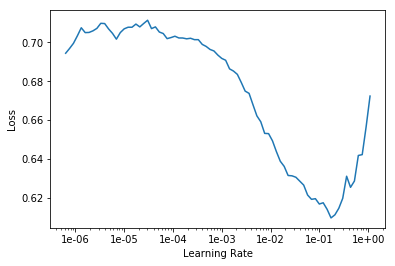

In [43]:
learn.recorder.plot()


In [44]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.563474,0.483536,0.816667,00:03


In [45]:
learn.save('first')

In [46]:
learn.load('first');

In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.521980,0.416165,0.796667,00:03


In [48]:
learn.save('second')

In [49]:
learn.load('second');

In [50]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.449083,0.389266,0.820000,00:05


In [51]:
learn.save('third')

In [52]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1698 items)
x: TextList
xxbos xxmaj so what i want to check on this , is go back to the one 's that xxmaj xxunk 's having issues with , and see if you can xxunk the xxunk .,xxbos i think there 's just so much i can take away from you , and it 's just so xxunk for our xxunk to kind of be xxunk of these little takeaways .,xxbos been working daily at an old xxunk in a xxunk xxunk of the xxunk , so she .,xxbos i 'd say , if you 're still looking for the sponsorship and if it 's still .,xxbos xxmaj um , think xxmaj voice xxmaj xxunk was the only one that had xxunk five million before xxmaj february there , and then they got that 14 .
y: CategoryList
1,0,0,0,0
Path: ../action-items-data/data-for-fastai;

Valid: LabelList (300 items)
x: TextList
xxbos xxmaj and i did some updates on the slides .,xxbos xxmaj make it relevant , make it relevant to xxmaj testfire . xxmaj like , how , think about , think when you think about um , the notes tha

In [53]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.417493,0.377853,0.840000,00:07
1,0.402407,0.369867,0.840000,00:07


In [54]:
learn.save('action-item-classifier')


In [55]:
learn.load('action-item-classifier')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (1698 items)
x: TextList
xxbos xxmaj so what i want to check on this , is go back to the one 's that xxmaj xxunk 's having issues with , and see if you can xxunk the xxunk .,xxbos i think there 's just so much i can take away from you , and it 's just so xxunk for our xxunk to kind of be xxunk of these little takeaways .,xxbos been working daily at an old xxunk in a xxunk xxunk of the xxunk , so she .,xxbos i 'd say , if you 're still looking for the sponsorship and if it 's still .,xxbos xxmaj um , think xxmaj voice xxmaj xxunk was the only one that had xxunk five million before xxmaj february there , and then they got that 14 .
y: CategoryList
1,0,0,0,0
Path: ../action-items-data/data-for-fastai;

Valid: LabelList (300 items)
x: TextList
xxbos xxmaj and i did some updates on the slides .,xxbos xxmaj make it relevant , make it relevant to xxmaj testfire . xxmaj like , how , think about , think when you think about um , the notes tha

In [56]:
learn2 = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn2.load('action-item-classifier')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (1698 items)
x: TextList
xxbos xxmaj so what i want to check on this , is go back to the one 's that xxmaj xxunk 's having issues with , and see if you can xxunk the xxunk .,xxbos i think there 's just so much i can take away from you , and it 's just so xxunk for our xxunk to kind of be xxunk of these little takeaways .,xxbos been working daily at an old xxunk in a xxunk xxunk of the xxunk , so she .,xxbos i 'd say , if you 're still looking for the sponsorship and if it 's still .,xxbos xxmaj um , think xxmaj voice xxmaj xxunk was the only one that had xxunk five million before xxmaj february there , and then they got that 14 .
y: CategoryList
1,0,0,0,0
Path: ../action-items-data/data-for-fastai;

Valid: LabelList (300 items)
x: TextList
xxbos xxmaj and i did some updates on the slides .,xxbos xxmaj make it relevant , make it relevant to xxmaj testfire . xxmaj like , how , think about , think when you think about um , the notes tha

In [57]:
learn2.predict("I'll get that to you as soon as I've finished it.")


(Category 1, tensor(1), tensor([0.0070, 0.9930]))

In [59]:
learn.predict("I'll get that to you as soon as I've finished it.")


(Category 1, tensor(1), tensor([0.0065, 0.9935]))

In [60]:
learn.predict("I think we did a little presentation at the end.")


(Category 0, tensor(0), tensor([0.6481, 0.3519]))

In [61]:
learn.predict("Okay, yeah that'd be great. And, I think like, I think where we need like the biggest muscle is um, you know um navigating . You know, especially like the provincial and federal um, opportunities and stuff, and what not. Um.")


(Category 0, tensor(0), tensor([0.8464, 0.1536]))

In [62]:
learn.predict("I'll give him a call later on today.")

(Category 1, tensor(1), tensor([0.0081, 0.9919]))